# PLEASE CLONE THIS NOTEBOOK INTO YOUR PERSONAL FOLDER
# DO NOT RUN CODE IN THE SHARED FOLDER

# HW 5 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In Weeks 8 and 9 you discussed key concepts related to graph based algorithms and implemented SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [0]:
%pip install networkx

Python interpreter will be restarted.
Requirement already satisfied: networkx in /databricks/python3/lib/python3.8/site-packages (2.6.3)
WARNING: You are using pip version 21.0.1; however, version 21.3.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-1ee91c72-f840-4635-ac51-527b65862ed3/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [0]:
# RUN THIS CELL AS IS. 
tot = 0
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
for item in dbutils.fs.ls(DATA_PATH):
  tot = tot+item.size
tot
# ~4.7GB

Out[2]: 4751198766

In [0]:
# RUN THIS CELL AS IS. You should see all-pages-indexed-in.txt, all-pages-indexed-out.txt and indices.txt in the results. If you do not see these, please let an Instructor or TA know.
display(dbutils.fs.ls(DATA_PATH))

path,name,size
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt,all-pages-indexed-in.txt,2143300687
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt,all-pages-indexed-out.txt,2090459616
dbfs:/mnt/mids-w261/HW5/indices.txt,indices.txt,517438296
dbfs:/mnt/mids-w261/HW5/test_graph.txt,test_graph.txt,167


In [0]:
sc = spark.sparkContext
spark

Out[4]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.0.128.14:7077 
 AppName 
 Databricks Shell

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Do not respond in terms of any specific algorithm. Think in terms of the nature of the graph datastructure itself).*

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ The hyperlink structure of the web (or web graph) is one dataset that can be appropriate to represent as a graph. The nodes in the dataset represent the various webpage URLs; the edges are the connections line between the source URL and the target URL. The web graph described here is directed, as one source URL may contain target URLs that do not refer back to the original source URL. The average 'in-degree' of a node in this context would be the number of URLs that have that node as a target URL.

> __b)__ Other than their scale and size, graphs are uniquely challenging to work with in the map-reduce paradigm because MapReduce does not provide any built-in mechanism for communicating global state across compute nodes. Put differently, one of the main challenges to "dividing and conquering" computations involving graphs is that the fundamental units of analysis (nodes and edges) carry information about each other so it often takes some careful planning to making sure that the appropriate information is co-located for the calculations we need to perform. This corresponds to the issue of traversing every node and its edges. Traversal is relatively simple on a single computer, but MapReduce requires traversals to be run in parallel. So this makes graphs uniquely challenging to work with.

> __c)__ Dijkstra's algorithm is an algorithm for finding the shortest paths between nodes in a graph. It uses a modified BFS with weights and a priority queue to find the shortest path. Dijkstra is a greedy algorithm, so we assume that we have made the best choice possible in every step of the algorithm.

> The algorithm goes as follows:

> For the current node, consider all of its unvisited neighbours and calculate their tentative distances through the current node. Compare the newly calculated tentative distance to the current assigned value and assign the smaller one. 
When we are done considering all of the unvisited neighbours of the current node, mark the current node as visited and remove it from the unvisited set. 

> If the destination node has been marked visited or if the smallest tentative distance among the nodes in the unvisited set is infinity, then stop. The algorithm has finished.
Otherwise, select the unvisited node that is marked with the smallest tentative distance, set it as the new "current node", and repeat.

> This process is hard to parallelize because you must have a complete representation of the graph in order for the algorithm to run. The information in each node is required at each step, which makes the graph traversal difficult in the parallel MapReduce 

> __d)__ Parallel breadth-first search gets around the problem mentioned in part c by iteratively moving through the graph structure and calculating the shortest paths in a step-wise fashion. In order to accomplish this the algorithm maps over all nodes and emits a key-value pair for each neighbor on the node's adjacency list (the key contains the node id of the neighbor and the value is the current distance to the node plus one, or the distance). After a shuffle and sort, the reducers will receive keys corresponding to the destination node ids and distances of all paths leading to that node, and select the shortest. Additionally, the structure of the graph is passed through each iteration to be updated. The cost of the parallel breadth-first-search algorithm is that it requires a large amount of calculation that will eventually be discarded (basically all path lengths that are *not* the shortest).

# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/Lin-Dyer-graph-Q1.png?raw=true" width=50%>

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.

### Q2 Student Answers:
> __a)__ Relatively speaking, the graph descript in Figure 5.1 is sparsely populated (9 connections out of a possible 20). Sparsity/density will impact how favorable one type of representation might be preferred for a given application over the other (ie, the more sparse a representation, the more adjacency lists would be favored; the more dense a representation, the less this favoritism exists).

> __b)__ The plotted graph is directed. In a directed graph, the adjacency matrices will have an asymmetry across the diagonal, as not all edges provide an equivalent relationship between nodes. In the adjacency matrix, all rows indicate a tail or a start of a potential edge, while the columns indicate the head or target of that edge. The cells in an adjacency matrix can have a value of 1 or 0 according to whether an undirected/directed edge exists or not between two vertices, respectively. Undirected graphs have edges that do not have a direction. So, the adjacency matrices for undirected graphs are symmetric along the diagonal. This is because each node-node relationship will have the same relation representation in the matrix. In comparison, directed graphs have edges with direction. The edges indicate a one-way relationship, in that each edge can only be traversed in a single direction. Thus, the matrix representation is not necessarily symmetric.

In [0]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

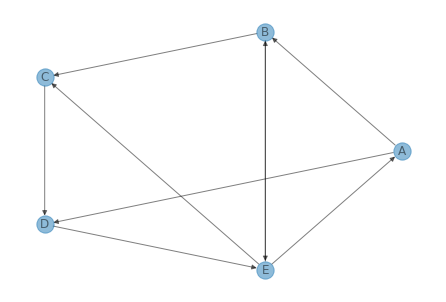

In [0]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for pair in graph['edges']:
        adj_matr.loc[pair[0],pair[1]] = 1
    ############### (END) YOUR CODE #################
    return adj_matr

In [0]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

A B C D E
A 0 1 0 1 0
B 0 0 1 0 1
C 0 0 0 1 0
D 0 0 0 0 1
E 1 1 1 0 0

In [0]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for edge in graph['edges']:
        adj_list[edge[0]].append(edge[1])  
    ############### (END) YOUR CODE #################
    return adj_list

In [0]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}

# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

### Q3 Student Answers:
> __a)__ In the context of a hypotheical infinite random walk, the PageRank metric represents the frequency that the (tireless) web surfer would encouter a particular Web Page, ie. it is the probability distribution that a particular Web Page would be arrived at by the surfer given a random walk (Lin & Dyer, 5.3).

> __b)__ The Markov Property of a random process (a Markov process) states that for any given time, the conditional distribution of future states of the process depend only on the present state and not the past states (memoryless). In the context of PageRank, this means that the probability of a user going from one webpage (state) to the next is dependent on the `transition probability`.

> __c)__ In the context of PageRank, $n$ states represents the number of possible web pages that the random surfer could be on at a given time. Since the transition probability matrix has dimensions of $n$ by $n$, the size will increase according to $n$^2.

> __d)__ A "right stochastic matrix" is the transition matrix, a square matrix of nonnegative real numbers with each row summing to 1. One eigenvector of the transition matrix has an eigenvalue of 1 and is all positive. Compared to the toy adjacency matrix of paths connecting nodes/webpages, the transition matrix represents the probabily of taking a given path from a given single webpage/node.

> __e)__ The process converges in five iterations. Node E is most central, which matches intuition since it has the most connections.

In [0]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

Out[11]:

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [0]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
transition_matrix = TOY_ADJ_MATR.div(TOY_ADJ_MATR.sum(axis = 1), axis = 0)

################ (END) YOUR CODE #################
print(transition_matrix)

A B C D E
A 0.000000 0.500000 0.000000 0.5 0.0
B 0.000000 0.000000 0.500000 0.0 0.5
C 0.000000 0.000000 0.000000 1.0 0.0
D 0.000000 0.000000 0.000000 0.0 1.0
E 0.333333 0.333333 0.333333 0.0 0.0

In [0]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    for iteration in range(nIter):
      tMatrix = np.dot(tMatrix, tMatrix)
      
      if verbose == True:
        print("Step:",iteration+1)
        print(tMatrix)
    
    state_vector = np.dot(xInit, tMatrix)
    ################ (END) YOUR CODE #################
    return state_vector

In [0]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)

Step: 1
[[0. 0. 0.25 0. 0.75 ]
 [0.16666667 0.16666667 0.16666667 0.5 0. ]
 [0. 0. 0. 0. 1. ]
 [0.33333333 0.33333333 0.33333333 0. 0. ]
 [0. 0.16666667 0.16666667 0.5 0.16666667]]
Step: 2
[[0. 0.125 0.125 0.375 0.375 ]
 [0.19444444 0.19444444 0.23611111 0.08333333 0.29166667]
 [0. 0.16666667 0.16666667 0.5 0.16666667]
 [0.05555556 0.05555556 0.13888889 0.16666667 0.58333333]
 [0.19444444 0.22222222 0.22222222 0.16666667 0.19444444]]
Step: 3
[[0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]
 [0.09915123 0.17091049 0.18595679 0.26967593 0.27430556]
 [0.09259259 0.125 0.17361111 0.20833333 0.40046296]
 [0.13348765 0.17978395 0.19598765 0.21990741 0.27083333]
 [0.09027778 0.1570216 0.18016975 0.26273148 0.30979938]]
Step: 4
[[0.10386392 0.15674096 0.18360648 0.23753577 0.31825288]
 [0.10663166 0.15881413 0.18475957 0.23582756 0.31396708]
 [0.10336291 0.15722612 0.18356785 0.23923236 0.31661076]
 [0.10553692 0.15721838 0.18414998 0.23524931 0.31784542]
 [0.10594847 0.15871693 0.18455766 0.23691844 0.3138585 ]]
Step: 5
[[0.10526656 0.15789725 0.18421194 0.23683994 0.3157843 ]
 [0.10525993 0.15789282 0.18420928 0.23684491 0.31579305]
 [0.10526734 0.1578958 0.18421186 0.23683618 0.31578881]
 [0.10526294 0.15789661 0.18421084 0.23684553 0.31578409]
 [0.10526136 0.15789283 0.18420967 0.23684231 0.31579383]]
Step: 6
[[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]]
Step: 7
[[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]]
Step: 8
[[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]]
Step: 9
[[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]]
Step: 10
[[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]]

__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.

### Q4 Student Answers:
> __a)__ After running the power iteration, we can see a problem with our results. With each iteration, the probabilities decrease in value and do not add up to 1 as expected. Also, the values do not converge and reach a steady state. This is most likely due to the “sink” Node E and the lack of “teleportation” in our current algorithm. Put differently, the transition matrix is no longer right stochastic matrix as the row 'E' does not sum to 1. This is because node 'E' is a dangling node, hence there are no outgoing probabilty mass in our current approach to the 'not nice' graph. If it is not a stochastic matrix, markov chains and transitions cannot be applied.

> __b)__ We can see that the E node does not connect back to any of the other nodes--it is a dangling node. This node causes problems because it is a sink node, meaning that there are no outgoing connections - only incoming. This means that the algorithm will get stuck at this node once it reaches it. So, sink nodes absorb the random surfer and set the PageRank of other pages to 0. To avoid this, we can modify the transition matrix after each iteration by adding virtual edges directed from sink nodes to all the other nodes. With this setting, the random surfer trapped in the sink nodes can jump to the other pages randomly.

> __c)__ An irreducible graph is one that has a state space is a single communicating class--i.e it is possible to get to any state from any state. The webgraph is not naturally irreducible. Web URLs that do not reference any other URLs (aka, dangling nodes) render it irreducible.

> __d)__ An aperiodic graph is one that has a greated common divisor of all cycle lengths equal to 1. The webgraph is not naturally aperiodic, it is possible that a webgraph has nodes that do not connect to other nodes or that the web graph has nodes that are self-referrential, violating aperiodicity.

> __e)__  To solve irreducibility and aperiodicity, the PageRank algorithm is given the ability to 'teleport' to any other nodes with a non-zero percentage. This can be done by replacing an all zero-probability row with probabilities of $1/n$. This ensures that the given row is right stochastic and maintains the irreducibility of the webgraph. Intuitively, this adjustment means that for pages that don't want to link out, the modified model automatically creates invisible links so that the algorithm never gets stuck; when the ‘random surfer’ enters a dangling node, he can hyperlink to any page at random. We can also implement teleportation in order to guarantee aperiodicity. So, a proportion of the time the random surfer will be following links at random and a proportion of the time he will be 'teleporting' to a new URL. The teleporting is random because the teleportation matrix is uniform, which means that the random surfer is equally likely to jump to any page when he teleports. These modifications will ensure both aperiodicity and irreducibility.

In [0]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

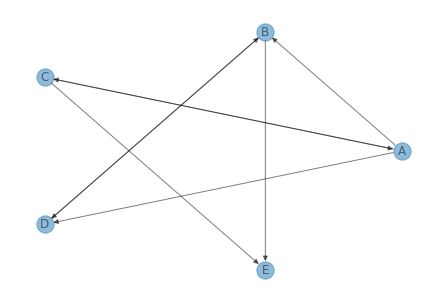

In [0]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
TOY_ADJ_MATR2 = get_adj_matr(TOY2_GRAPH)
transition_matrix2 = TOY_ADJ_MATR2.div(TOY_ADJ_MATR2.sum(axis = 1), axis = 0).fillna(0)
print(transition_matrix2)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix2, 10, verbose = True)
################ (END) YOUR CODE #################

A B C D E
A 0.0 0.333333 0.333333 0.333333 0.0
B 0.0 0.000000 0.000000 0.500000 0.5
C 0.5 0.000000 0.000000 0.000000 0.5
D 0.0 1.000000 0.000000 0.000000 0.0
E 0.0 0.000000 0.000000 0.000000 0.0
Step: 1
[[0.16666667 0.33333333 0. 0.16666667 0.33333333]
 [0. 0.5 0. 0. 0. ]
 [0. 0.16666667 0.16666667 0.16666667 0. ]
 [0. 0. 0. 0.5 0.5 ]
 [0. 0. 0. 0. 0. ]]
Step: 2
[[0.02777778 0.22222222 0. 0.11111111 0.13888889]
 [0. 0.25 0. 0. 0. ]
 [0. 0.11111111 0.02777778 0.11111111 0.08333333]
 [0. 0. 0. 0.25 0.25 ]
 [0. 0. 0. 0. 0. ]]
Step: 3
[[0.0007716 0.0617284 0. 0.0308642 0.0316358 ]
 [0. 0.0625 0. 0. 0. ]
 [0. 0.0308642 0.0007716 0.0308642 0.03009259]
 [0. 0. 0. 0.0625 0.0625 ]
 [0. 0. 0. 0. 0. ]]
Step: 4
[[5.95374181e-07 3.90565463e-03 0.00000000e+00 1.95282731e-03
 1.95342269e-03]
 [0.00000000e+00 3.90625000e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
 [0.00000000e+00 1.95282731e-03 5.95374181e-07 1.95282731e-03
 1.95223194e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90625000e-03
 3.90625000e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]]
Step: 5
[[3.54470415e-13 1.52587887e-05 0.00000000e+00 7.62939435e-06
 7.62939471e-06]
 [0.00000000e+00 1.52587891e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
 [0.00000000e+00 7.62939435e-06 3.54470415e-13 7.62939435e-06
 7.62939400e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.52587891e-05
 1.52587891e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]]
Step: 6
[[1.25649275e-25 2.32830644e-10 0.00000000e+00 1.16415322e-10
 1.16415322e-10]
 [0.00000000e+00 2.32830644e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
 [0.00000000e+00 1.16415322e-10 1.25649275e-25 1.16415322e-10
 1.16415322e-10]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.32830644e-10
 2.32830644e-10]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]]
Step: 7
[[1.57877404e-50 5.42101086e-20 0.00000000e+00 2.71050543e-20
 2.71050543e-20]
 [0.00000000e+00 5.42101086e-20 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
 [0.00000000e+00 2.71050543e-20 1.57877404e-50 2.71050543e-20
 2.71050543e-20]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.42101086e-20
 5.42101086e-20]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]]
Step: 8
[[2.49252746e-100 2.93873588e-039 0.00000000e+000 1.46936794e-039
 1.46936794e-039]
 [0.00000000e+000 2.93873588e-039 0.00000000e+000 0.00000000e+000
 0.00000000e+000]
 [0.00000000e+000 1.46936794e-039 2.49252746e-100 1.46936794e-039
 1.46936794e-039]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.93873588e-039
 2.93873588e-039]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000]]
Step: 9
[[6.21269312e-200 8.63616856e-078 0.00000000e+000 4.31808428e-078
 4.31808428e-078]
 [0.00000000e+000 8.63616856e-078 0.00000000e+000 0.00000000e+000
 0.00000000e+000]
 [0.00000000e+000 4.31808428e-078 6.21269312e-200 4.31808428e-078
 4.31808428e-078]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 8.63616856e-078
 8.63616856e-078]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000]]
Step: 10
[[0.00000000e+000 7.45834073e-155 0.00000000e+000 3.72917037e-155
 3.72917037e-155]
 [0.00000000e+000 7.45834073e-155 0.00000000e+000 0.00000000e+000
 0.00000000e+000]
 [0.00000000e+000 3.72917037e-155 0.00000000e+000 3.72917037e-155
 3.72917037e-155]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 7.45834073e-155
 7.45834073e-155]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000]]

# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [0]:
dbutils.fs.ls(DATA_PATH)

Out[18]: [FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt', name='all-pages-indexed-in.txt', size=2143300687),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt', name='all-pages-indexed-out.txt', size=2090459616),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/indices.txt', name='indices.txt', size=517438296),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/test_graph.txt', name='test_graph.txt', size=167)]

In [0]:
# open test_graph.txt file to see format (RUN THIS CELL AS IS)
with open('/dbfs/mnt/mids-w261/HW5/test_graph.txt', "r") as f_read:
  for line in f_read:
    print(line)

2	{'3': 1}

3	{'2': 2}

4	{'1': 1, '2': 1}

5	{'4': 3, '2': 1, '6': 1}

6	{'2': 1, '5': 2}

7	{'2': 1, '5': 1}

8	{'2': 1, '5': 1}

9	{'2': 1, '5': 1}

10	{'5': 1}

11	{'5': 2}

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

In [0]:
# display testRDD (RUN THIS CELL AS IS)
testRDD.take(10)

Out[21]: ["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [0]:
# display indexRDD (RUN THIS CELL AS IS)
indexRDD.take(10)

Out[22]: ['! $var = &quot;&quot;\t1\t1\t0',
 '! (CONFIG.SYS directive)\t2\t1\t1',
 '! (album)\t3\t12\t17',
 '! (disambiguation)\t4\t1\t20',
 '! -attention-\t5\t1\t0',
 '! Time Zone\t6\t1\t0',
 '!! (chess)\t7\t0\t1',
 '!! (disambiguation)\t8\t3\t0',
 '!!! (Chk Chk Chk)\t9\t1\t0',
 '!!! (album)\t10\t5\t15']

In [0]:
# display wikiRDD (RUN THIS CELL AS IS)
wikiRDD.take(10)

Out[23]: ["73\t{'14417532': 1}",
 "299\t{'4214575': 1}",
 "2552\t{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}",
 "2570\t{'983991': 1}",
 "2616\t{'9045350': 1}",
 "2711\t{'752887': 1}",
 "2818\t{'3534183': 1}",
 "2847\t{'3797918': 1}",
 "2892\t{'2893': 1}",
 "2921\t{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}"]

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__ The raw data is an adjacency list of wikimedia nodes. The first value represents the node, the second part of each line is the adjacency list for that particular node.

> __b)__ This is not the same number of nodes in the graph because dangling nodes do not have adjacency lists and are therefore do not have their own record in the dataset.

> __d)__ There are (15,192,277 -  5,781,290) dangling nodes, or 9,410,987 dangling nodes.

In [0]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
# 5781290
print(wikiRDD.count())

5781290

In [0]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############

    def getNodes(line):
        """
        input: raw data line
        output: (node,1) 
        all nodes that appear in a line are the key, and the keys within the dictionary
        """
        source_node, adjacent_nodes = line.split('\t')[0], set(ast.literal_eval(line.split('\t')[1]).keys())
        
        yield source_node
        
        for adjacent_node in adjacent_nodes:
            yield adjacent_node
    
    # Spark Job
    # Parse raw data and return all nodes in a line of raw data
    # Keep unique/distinct nodes 
    # Count distinct nodes 
    
    totalCount = dataRDD.flatMap(getNodes) \
                        .distinct() \
                        .count()
    
    ############## (END) YOUR CODE ###############   
    return totalCount

In [0]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 0.2037365436553955 seconds.
Total Nodes: 11

In [0]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 305.65930128097534 seconds.
Total Nodes: 15192277

# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ There are three distinct factors that determine the PageRank of a node: the number of links it receives, the link propensity of the linkers, and the centrality of the linkers. The PageRank is calculated by the number and value of incoming links to a website. Yet, the information about a node’s out-degree is also important with regard to centrality. Reasonably, the value of the endorsement depreciates proportionally to the number of links given out by the endorsing node. So, the PageRank centrality $x{i}$ of node $i$ is given by: $$x_i = \alpha \sum_k \frac{a\{k,i}}{d_k} \, x_k + \beta$$ where $\alpha$ and $\beta$ are constants and $d_k$ is the out-degree of node $k$ if such degree is positive, or $d_k = 1$ if the out-degree of $k$ is null. 

> __c)__ A node is considered to be a “sink” if its out-degree is 0. This means that there are only incoming links to the node with no other links to follow and “flow” out of. PageRank handles these nodes differently than others by implementing teleportation and setting a default out-node value to 1 when calculating the centrality.

In [0]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############

    # helper function
    def getNodes(pair):
        """
        input: source_node, edges_dictionary
        output: (node, number of outlinks) for all (source & adjacement nodes)
        """
        
        yield (pair[0], sum(pair[1].values()))
        
        for adjacent_node in set(pair[1].keys()):
            yield (adjacent_node,0)
    
    
    # Spark Job
    # parse raw data to get (node, edges_dictionary)
    # map (node, edges_dictionary) to become (node, total_outlinks)
    # reduceByKey to remove duplicates and add outlinks
    
    nodeOutDegrees = dataRDD.map(parse) \
                            .map(lambda x: (x[0],sum(x[1].values()))) \
                            .cache()

    # take n nodes sorted by node with the most outlinks
    top = nodeOutDegrees.takeOrdered(10, key=lambda x: -x[1])
    
    # find average num of outlinks for nondangling nodes
    avgDegree = nodeOutDegrees.map(lambda x: x[1]).mean()
    
    # sample
    sampledCounts = nodeOutDegrees.values().takeSample(False,n, seed=261)
    
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

In [0]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])

... completed job in 0.40033745765686035 seconds
Average out-degree: 2.2
Top 10 nodes (by out-degree:)
 [('5', 5), ('6', 3), ('3', 2), ('4', 2), ('7', 2), ('8', 2), ('9', 2), ('11', 2), ('2', 1), ('10', 1)]

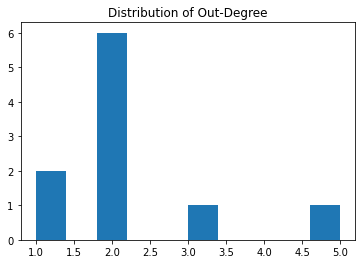

In [0]:
# part a - plot results from test file (RUN THIS CELL AS IS)
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
display(plt.show())

In [0]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)

print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])

... completed job in 142.72140622138977 seconds
Average out-degree: 32.04181575392317
Top 10 nodes (by out-degree:)
 [('7804599', 9347), ('7858931', 8910), ('11185362', 8837), ('7705822', 8142), ('5760310', 7649), ('7865920', 7608), ('7819767', 7278), ('7883280', 7231), ('13035895', 7126), ('7880980', 6904)]

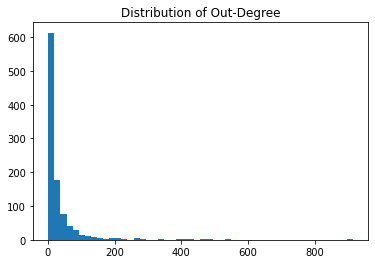

In [0]:
# part a - plot results from full file (RUN THIS CELL AS IS)
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
display(plt.show())

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code \\(N\\).

### Q7 Tasks:
* __a) short response:__ What is \\(N\\)? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to \\(\frac{1}{N}\\). (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute \\(N\\) before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__ N is the total number of nodes in the graph, including the dangling nodes. We initialize each node to 1/N representing equal probability of going from any node to any other node. Using the analogy of the surfer, this means that the probability of a random websurfer arriving at each webpage is the same.

> __b)__ Computing N only after initializing all nodes RDD is more efficient. To find N we need to run spark job that counts the nodes and the edges to incldue dangling nodes. If we use countNodes function from the previous question to get N, we need to repeat the spark job to build the all nodes RDD, which involves two map-reduce jobs. By builidng all nodes that includes dangling nodes first and then counting the final RDD, we can optimize this into a single pass.

In [0]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############
    
    
    # write any helper functions here
    def getNodes(line):
        """
        input: raw data line
        output: (node, str(edges_dictionary))
        """
        source_node, edges_dict = line.split('\t')[0], ast.literal_eval(line.split('\t')[1])
        
        yield (source_node, str(edges_dict))
        
        for adjacent_node in set(edges_dict.keys()):
            yield (adjacent_node, '') 
    
    # write your main Spark code here
    # Spark Job
    # parse the data and output (node, str(edges_dict))
    # reduce nodes: nondangling nodes will be merged with their "dangling node" versions
    # cache to calculate N
    # map the result format (node, (initial rank, str(edge_dictionary)))
    
    result = dataRDD.flatMap(getNodes) \
                    .reduceByKey(lambda x,y: x+y) \
                    .cache()
    
    rank = sc.broadcast(1.0/result.count())
    
    # fix dangling nodes so that the string contains an empty dictionary
    graphRDD = result.map(lambda x: (x[0], (rank.value, '{}')) if len(x[1])==0 else (x[0], (rank.value, x[1]))).cache()

    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [0]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 0.3680262565612793 seconds.
Out[34]: [('8', (0.09090909090909091, "{'2': 1, '5': 1}")),
 ('9', (0.09090909090909091, "{'2': 1, '5': 1}")),
 ('10', (0.09090909090909091, "{'5': 1}")),
 ('4', (0.09090909090909091, "{'1': 1, '2': 1}")),
 ('1', (0.09090909090909091, '{}')),
 ('2', (0.09090909090909091, "{'3': 1}")),
 ('3', (0.09090909090909091, "{'2': 2}")),
 ('5', (0.09090909090909091, "{'4': 3, '2': 1, '6': 1}")),
 ('6', (0.09090909090909091, "{'2': 1, '5': 2}")),
 ('7', (0.09090909090909091, "{'2': 1, '5': 1}")),
 ('11', (0.09090909090909091, "{'5': 2}"))]

In [0]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 384.25874638557434 seconds

In [0]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 15192277
First record: [('6312944', (6.582291778908455e-08, "{'188146': 1, '5860442': 1, '151601': 1, '10332952': 3, '120394': 1, '180590': 1, '9160795': 1, '8355026': 1, '848339': 5, '1493115': 1, '1025763': 1, '265441': 1, '124888': 1, '9159937': 2, '159392': 1, '6378177': 1, '8885023': 1, '3028515': 1, '4640668': 1, '162283': 1, '264922': 1, '6312955': 1, '272450': 1, '340878': 1, '5345143': 12, '9379841': 2, '11426653': 3, '3739196': 1, '121807': 1, '4640644': 1, '2257508': 1, '6637089': 2, '180323': 1, '9667180': 6, '357671': 1, '6313036': 1, '123327': 1, '159168': 1, '6312950': 1, '7338372': 1, '1937437': 5, '12059168': 1, '10293612': 1, '9387194': 1, '2938523': 1, '413084': 1, '156726': 1, '562978': 1, '151429': 1, '7040971': 1, '3739247': 1, '11269539': 1, '149164': 1, '183742': 1, '126516': 1, '10231747': 1, '4245167': 1, '2737080': 3, '9160182': 1, '9160169': 1, '3739263': 1, '3450210': 1, '3786818': 3, '1062600': 1, '4615701': 1, '133586': 1, '6637090': 1, '184048': 1, '5860605': 1, '191498': 1, '2722957': 1, '6513610': 1, '6299587': 3, '6313034': 1, '394115': 1, '13242181': 1, '8884073': 1, '148973': 1, '854364': 1, '10333601': 1, '6956944': 3, '2962999': 1, '6538701': 4, '12062740': 1, '6282191': 1, '13242294': 2, '195363': 2, '411880': 1, '3485441': 1, '7541268': 1, '162046': 1, '1746689': 2, '11448603': 1, '191801': 1, '142180': 1, '13851460': 1, '849278': 1, '271900': 1, '6536378': 2, '8019550': 1, '195712': 1, '195708': 1}"))]
... initialization continued: 9.29784893989563 seconds

# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/PR-illustrated.png?raw=true' width=50%>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ $\alpha$ is the probability where a random walker can teleport to any other page in the webgraph. With 1/G chance of landing at any page, the total probability of teleporting becomes $\alpha * \frac{1}{|G|}$.

> __b)__ $m$ is the aggregate dangling node mass, which is equally distributed to each node in the graph. Therefore, each node recieves $m/|G|$ mass from all the dangling nodes.

> __c)__ Total probability mass should always sum up to 1 (or an approximation to 1) at each iteration.

In [0]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [0]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.
    
    def missingMass(line):
        """
        Gather missing mass from dangling nodes to be redistributed to all other nodes 
        input: (source_node, (score,edges_dict_str))
        """
        score, edges_dict_str = line[1][0], line[1][1]
        
        if len(edges_dict_str) == 2: # empty edge_dicts_str has len('{}') == 2
            mmAccum.add(score)
    
    def redistributeScore(line):
        """
        Redistribute the probability of a given node to all of its edge nodes
        input: (source_node, (score, edges_dict_str))
        output: (sore_node, (rank, edges_dict_str)))
        """
        source_node, score, edges_dict = line[0], line[1][0], ast.literal_eval(line[1][1])
        
        # Dangling Nodes emits itself with an empty rank and edges dictionary
        if len(line[1][1]) == 2: # empty edge_dicts_str has len('{}') == 2
            yield (source_node,(0,'{}'))
        
        # Nondangling Nodes emits the source node with 0 score and the edge dictionary 
        # Nondangling Nodes also emits adjacent node with the redistrirubted score and empty string
        else:
            yield (source_node,(0,line[1][1]))
            
            rank = score/sum(edges_dict.values())
            
            for adjacent_node in set(edges_dict.keys()):
                yield (adjacent_node, ((edges_dict[adjacent_node]*rank,''))) 
    
    def updateRank(line):
        """
        Update P (rank) to account for teleportation and redistributing dangling node missing mass
        input: (source_node, (rank, edges_dict_str))
        output: (source_node, (updated rank, edges_dict_str))
        """
        
        new_rank = (a.value/G.value) + (d.value*(m.value/G.value+line[1][0]))
        
        return (line[0], (new_rank,line[1][1]))
    
    def totalProb(line):
        """
        Track the updated Ranks for every node and make sure they sum to 1
        input: (source_node, (rank, edges_dict_str))
        """
        totAccum.add(line[1][0])
 
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    
    # Spark Job
    # Step 0: store total nodes in graph and broadcast
    # Step 1: increment mmAccum using foreach() get the missing mass from dangling nodes
    # Step 2: mapper - redistribute score mass from source node to adjacent nodes (if source is dangling node, emit zero mass and zero edges)
    # Step 3: reduce - aggregate redistributed scores and edges_dict_str to get unique records
    # Step 4: mapper - update the score using UpdateRank helper function
    # Step 5: increment totAccum using foreach() to make sure probabilities add to 1
    
    G = sc.broadcast(graphInitRDD.count())
    
    for n in range(maxIter):
        graphInitRDD.foreach(missingMass)
        m = sc.broadcast(mmAccum.value)
    
        result= graphInitRDD.flatMap(redistributeScore) \
                            .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1])) \
                            .map(updateRank) \
                            .cache()
    
        result.foreach(lambda x: totAccum.add(x[1][0]))
        
        graphInitRDD = result 
        
        if verbose == True:
            print('iteration {}: missing mass = {}, total mass = {}'.format(n+1, m.value, totAccum.value))
        
        mmAccum.value = FloatAccumulatorParam.zero(mmAccum,0.0)
        totAccum.value = FloatAccumulatorParam.zero(totAccum,0.0)
    
    steadyStateRDD = graphInitRDD.map(lambda x: (x[0], x[1][0]))

    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [0]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

...trained 20 iterations in 5.591312408447266 seconds.
Top 20 ranked nodes:
Out[49]: [('2', 0.3620640495978871),
 ('3', 0.333992700474142),
 ('5', 0.08506399429624555),
 ('4', 0.06030963508473455),
 ('1', 0.04255740809817991),
 ('6', 0.03138662354831139),
 ('8', 0.01692511778009981),
 ('9', 0.01692511778009981),
 ('10', 0.01692511778009981),
 ('7', 0.01692511778009981),
 ('11', 0.01692511778009981)]

__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```

In [0]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])

iteration 1: missing mass = 0.6194586235839131, total mass = 0.9999999999743991
iteration 2: missing mass = 0.49623665520525073, total mass = 0.9999999999795381
iteration 3: missing mass = 0.45845896638840383, total mass = 0.9999999999746473
iteration 4: missing mass = 0.44518624578838584, total mass = 0.9999999999792756
iteration 5: missing mass = 0.4402014781797491, total mass = 0.999999999982063
iteration 6: missing mass = 0.43818412109072125, total mass = 0.9999999999853544
iteration 7: missing mass = 0.4373267618587093, total mass = 0.9999999999927044
iteration 8: missing mass = 0.43694515814089724, total mass = 0.9999999999925239
iteration 9: missing mass = 0.43676848971700405, total mass = 0.9999999999904369
iteration 10: missing mass = 0.43668343042476787, total mass = 0.9999999999894578
...trained 10 iterations in 5994.859499692917 seconds.
Top 20 ranked nodes:
Out[50]: [('13455888', 0.0015447247129693994),
 ('4695850', 0.0006710240718848119),
 ('5051368', 0.0005983856809695506),
 ('1184351', 0.0005982073536424939),
 ('2437837', 0.00046249289288990904),
 ('6076759', 0.00045509400641061777),
 ('4196067', 0.00044237788883337933),
 ('13425865', 0.0004415535171391725),
 ('6172466', 0.00042240020018092085),
 ('1384888', 0.0004012895604045954),
 ('6113490', 0.0003957892477153139),
 ('14112583', 0.00039438472837163954),
 ('7902219', 0.0003700987847324849),
 ('10390714', 0.0003650264964294881),
 ('12836211', 0.0003619948863075227),
 ('6237129', 0.00035195558475936147),
 ('6416278', 0.0003486623564496341),
 ('13432150', 0.0003393651063709873),
 ('1516699', 0.0003329750028594721),
 ('7990491', 0.0003076090626557442)]

In [0]:
top_20 = full_results.takeOrdered(20, key=lambda x: - x[1])

In [0]:
# Save the top_20 results to disc for use later. So you don't have to rerun everything if you restart the cluster.
np.save("top_20.csv", top_20)

In [0]:
# view record from indexRDD (RUN THIS CELL AS IS)
# title\t indx\t inDeg\t outDeg
indexRDD.take(1)

Out[53]: ['! $var = &quot;&quot;\t1\t1\t0']

In [0]:
# map indexRDD to new format (index, name) (RUN THIS CELL AS IS)
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
# see new format (RUN THIS CELL AS IS)
namesKV_RDD.take(2)

Out[55]: [(1, '! $var = &quot;&quot;'), (2, '! (CONFIG.SYS directive)')]

# OPTIONAL
### The rest of this notebook is optional and doesn't count toward your grade.
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and thier IDs.

* __a) code:__ Join this dataset with your top 20 results.
* __b) code:__ Print the results

## Join with indexRDD and print pretty

In [0]:
# part a
joinedWithNames = None
############## YOUR CODE HERE ###############

############## END YOUR CODE ###############

In [0]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

## OPTIONAL - GraphFrames
GraphFrames is a graph library which is built on top of the Spark DataFrames API.

* __a) code:__ Using the same dataset, run the graphframes implementation of pagerank.
* __b) code:__ Join the top 20 results with indices.txt and display in the same format as above.
* __c) short answer:__ Compare your results with the results from graphframes.

__NOTE:__ Feel free to create as many code cells as you need. Code should be clear and concise - do not include your scratch work. Comment your code if it's not self annotating.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from graphframes import *
from pyspark.sql import functions as F

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

### You will need to generate vertices (v) and edges (e) to feed into the graph below. 
Use as many cells as you need for this task.

In [0]:
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)


In [0]:
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.15, maxIter=10)

In [0]:
start = time.time()
top_20 = results.vertices.orderBy(F.desc("pagerank")).limit(20)
print(f'... completed job in {time.time() - start} seconds.')

In [0]:
%%time
top_20.show()

### Run the cells below to join the results of the graphframes pagerank algorithm with the names of the nodes.

In [0]:
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
namesKV_DF = namesKV_RDD.toDF()

In [0]:
namesKV_DF = namesKV_DF.withColumnRenamed('_1','id')
namesKV_DF = namesKV_DF.withColumnRenamed('_2','title')
namesKV_DF.take(1)

In [0]:
resultsWithNames = namesKV_DF.join(top_20, namesKV_DF.id==top_20.id).orderBy(F.desc("pagerank")).collect()

In [0]:
# TODO: use f' for string formatting
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in resultsWithNames:
    print ("{:6f}\t| {:10s}\t| {}".format(r[3],r[2],r[1]))

### Congratulations, you have completed HW5! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform